#### Model 2: Building a Convolutional neural network (CNN)

- CNNs are also known as ConvNets.
- CNNs are knwown for their capabilities in finding patterns in visual data.
- Steps in modelling with CNNs in PyTorch:
    - Creating a CNN model with PyTorch
    - Picking a loss and optimizer
    - Training the model
    - Evaluating the model
    - Saving and loading the model

![Screenshot from 2024-06-28 15-49-19.png](<attachment:Screenshot from 2024-06-28 15-49-19.png>)

![Screenshot from 2024-06-29 13-39-35.png](<attachment:Screenshot from 2024-06-29 13-39-35.png>)

#### Resources

- [CNN explainer](https://poloclub.github.io/cnn-explainer/)
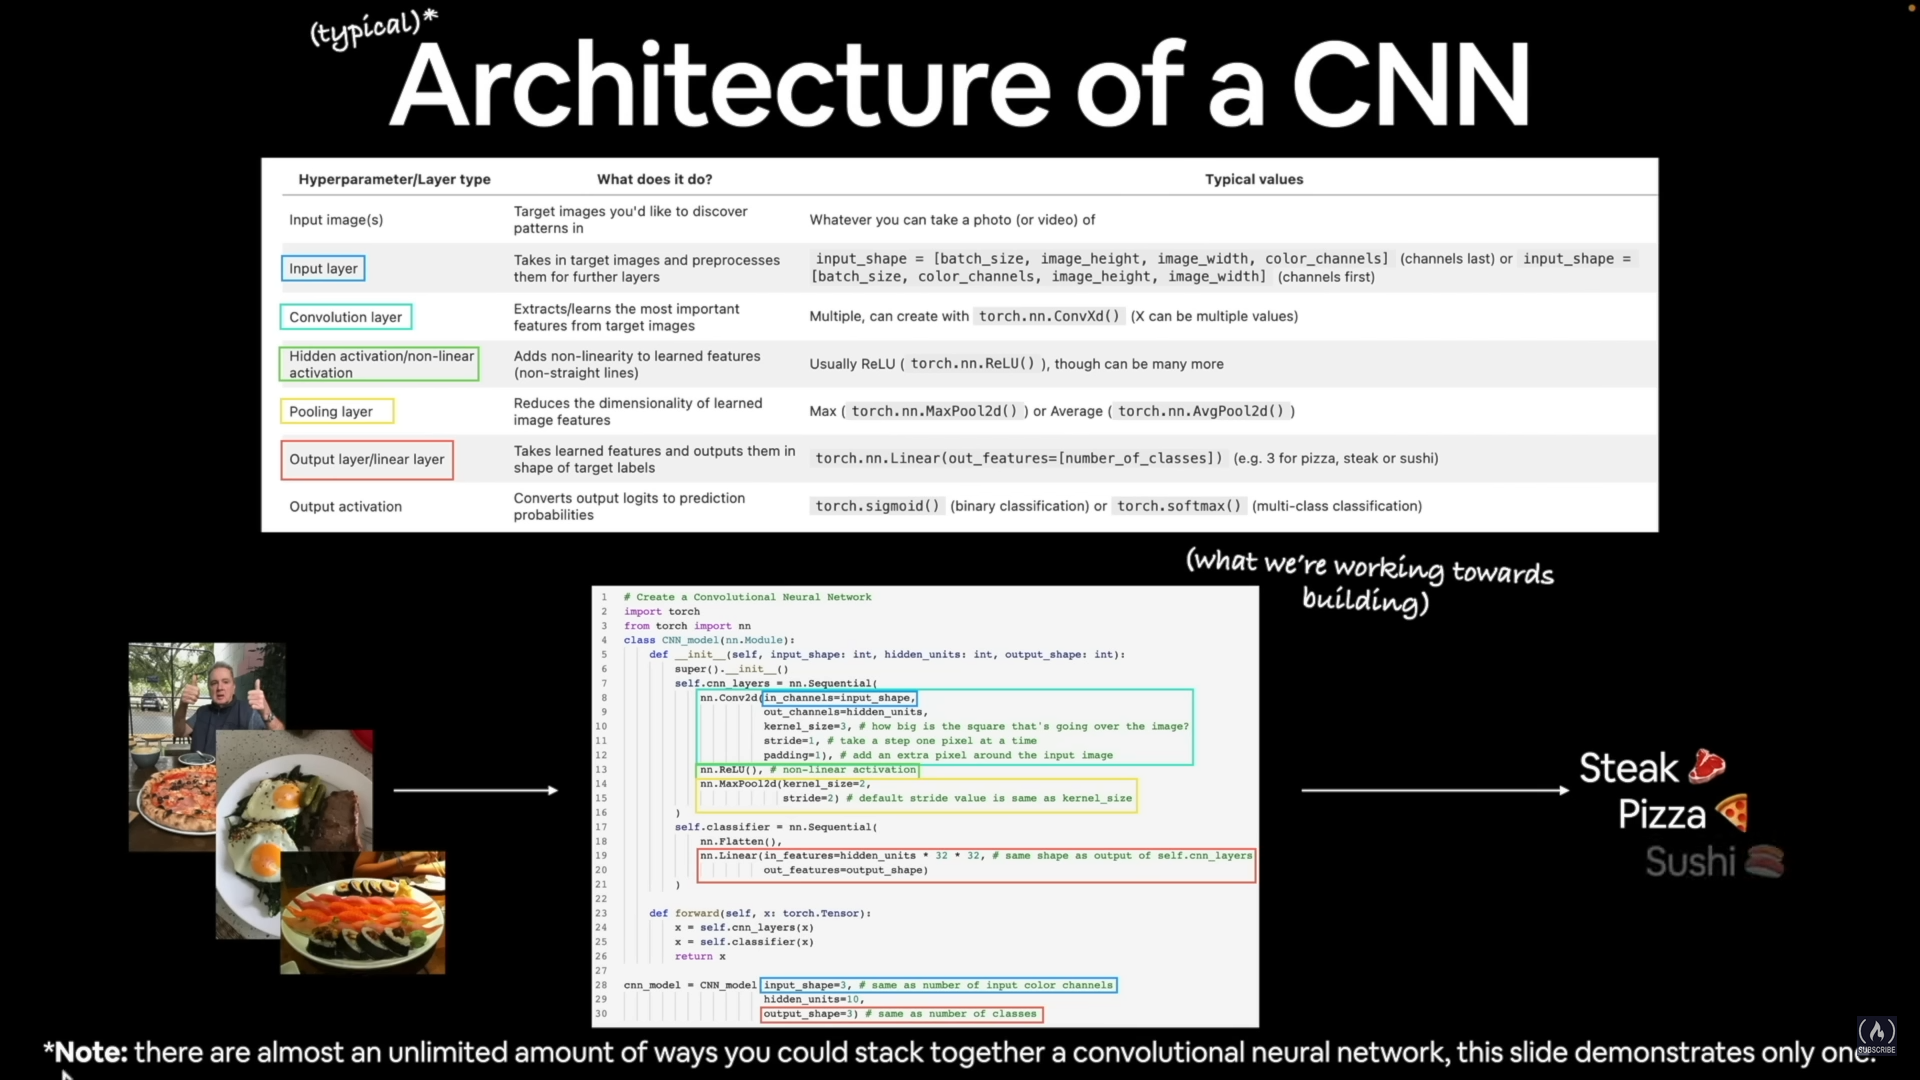
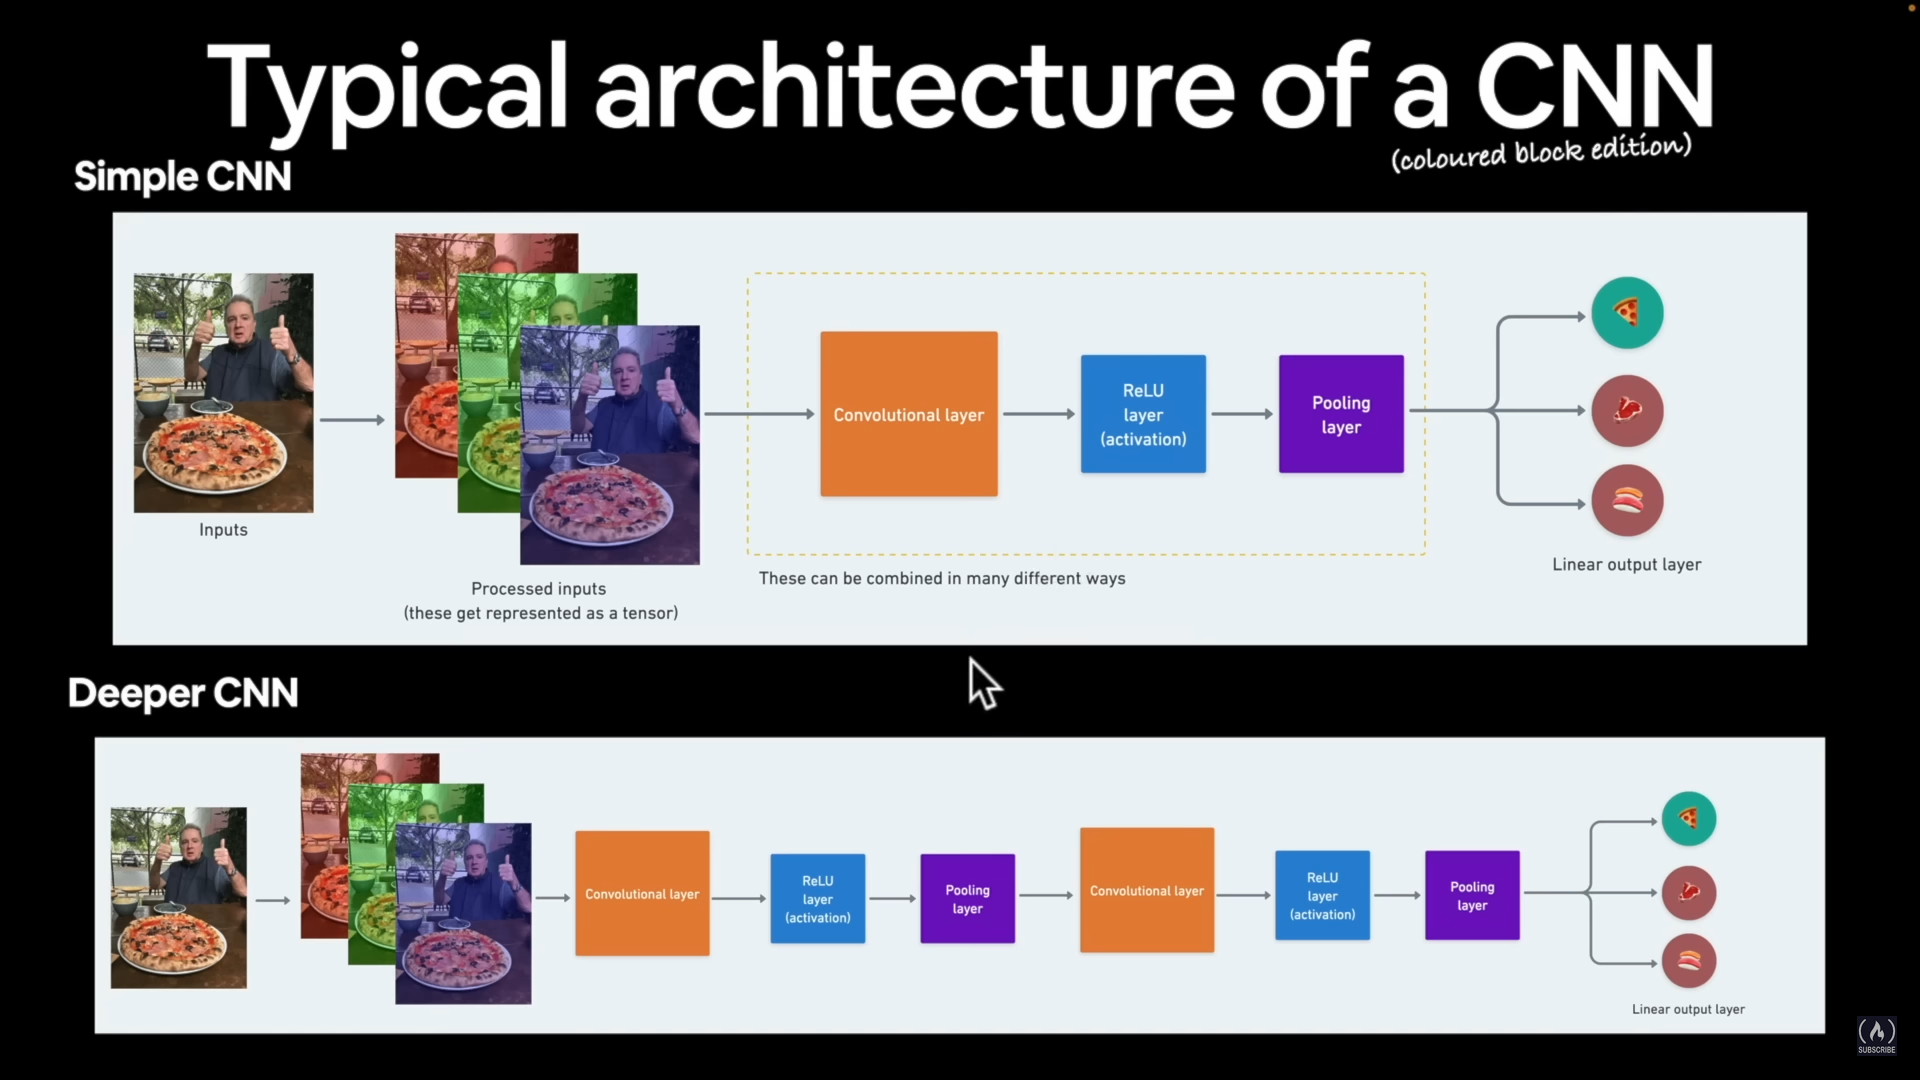

In [58]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [59]:
training_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=ToTensor(),
    target_transform=None # how do we want to transform the labels?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_to_idx = training_data.class_to_idx
class_names = training_data.classes
device = "cuda" if torch.cuda.is_available() else "cpu"

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

# in test data, its generally faster to not shuffle, plus, having mixed up batches won't add anything 
# to the training process
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
import tqdm.auto as tqdm

# 4 Make predictions and get model_0 results
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = "cpu"):
    loss, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            y_pred = model(X)
            # 2. Calculate loss and accuracy
            loss += loss_fn(y_pred, y)
            # For accuracy, need the prediction labels (logits -> pred labels)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with nn.Module
            "model_loss": loss.item(),
            "model_acc": acc}

In [61]:
from typing import Callable


def train_step(model: nn.Module,
               train_dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               accuracy_fn: Callable,
               device: torch.device = device):
    
    """Performs a training with model trying to learn on train_dataloader"""
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train() # train mode

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1)) # go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [62]:
def test_step(model: nn.Module, 
              test_dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn: Callable,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y)
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1)) # go from logits -> pred labels

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"\nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [63]:
def train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [64]:
# create a CNN model
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # a group of Conv2d, ReLu and MaxPool2d is called a "conv block"
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*6*6, # this is based on the output of the previous conv layers
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print("Out shape after conv block 1:", x.shape)
        x = self.conv_block_2(x)
        # print("Out shape after conv block 2:", x.shape)
        x = self.classifier(x)
        # print("Out shape after conv block 3:", x.shape)
        return x

In [65]:
torch.manual_seed(42)
# input shape is the number of color channels (1 for grayscale)
model = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
model

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=10, bias=True)
  )
)

#### 7.1 Stepping through the `nn.Conv2d()`

see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [66]:
images = torch.rand(32, 3, 64, 64)
test_image = images[0]
print(test_image.shape)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
test_image_pooled = conv_layer(test_image)
print(test_image_pooled.shape)

torch.Size([3, 64, 64])
torch.Size([10, 62, 62])


In [67]:
# create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)

# pass the data through the conv layer
conv_output = conv_layer(test_image)

print(conv_output.shape)

torch.Size([10, 64, 64])


#### 7.2 stepping through `nn.MaxPool2d()`

see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

In [68]:
test_image.shape

torch.Size([3, 64, 64])

In [69]:
# create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

print("Original shape: ", test_image.shape)
print("Original shape with unsqueeze: ", test_image.unsqueeze(dim=0).shape)

conv_output = conv_layer(test_image.unsqueeze(dim=0))
print("Shape after conv:", conv_output.shape)

# pass the data through the max pool layer
max_pool_output = max_pool_layer(conv_output)

print("Shape after max pool:", max_pool_output.shape)

Original shape:  torch.Size([3, 64, 64])
Original shape with unsqueeze:  torch.Size([1, 3, 64, 64])
Shape after conv: torch.Size([1, 10, 64, 64])
Shape after max pool: torch.Size([1, 10, 32, 32])


In [70]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print("Random tensor: \n", random_tensor)
print("Random tensor shape: \n", random_tensor.shape)

max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size

max_pool_tensor = max_pool_layer(random_tensor)
print("Max pool tensor: \n", max_pool_tensor)
print("Max pool tensor shape: \n", max_pool_tensor.shape)

Random tensor: 
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: 
 torch.Size([1, 1, 2, 2])
Max pool tensor: 
 tensor([[[[0.3367]]]])
Max pool tensor shape: 
 torch.Size([1, 1, 1, 1])


In [71]:
batch, images = next(iter(train_dataloader))
batch.shape, images.shape, batch[0].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]), torch.Size([1, 28, 28]))

In [72]:
images

tensor([4, 8, 1, 2, 4, 8, 0, 3, 3, 9, 0, 5, 0, 4, 7, 4, 0, 0, 4, 9, 6, 5, 4, 8,
        4, 2, 2, 0, 0, 4, 2, 9])

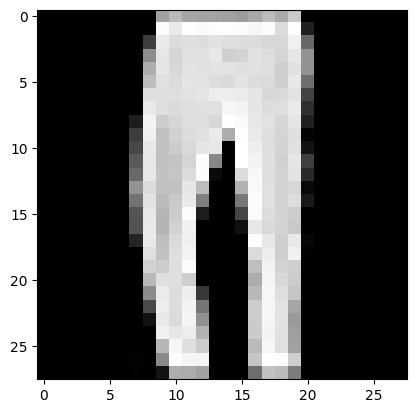

In [73]:
plt.imshow(batch[2].squeeze(), cmap="gray")

In [74]:
print(batch[2].unsqueeze(0).shape)
 # without adding the *6*6 in the linear layer in the model we would get a shape error, 
 # and that error will help us determine the correct shape of the in_features.
pred = model(batch[2].unsqueeze(0))

pred

torch.Size([1, 1, 28, 28])


tensor([[-0.0505,  0.0366, -0.0132,  0.0104, -0.0139,  0.0723,  0.1009, -0.0366,
         -0.0386, -0.0587]], grad_fn=<AddmmBackward0>)

#### 7.3 Setup a loss function and optimizer

In [75]:
# setup loss and optimizer, metrics

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [76]:
from tqdm.auto import tqdm
torch.manual_seed(42)
from timeit import default_timer as timer
train_start = timer()
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_step(model, test_dataloader, loss_fn, accuracy_fn)

train_end = timer()
total_train_time_model_0 = train_time(start=train_start, end=train_end, device=str(next(model.parameters()).device))


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------


Train loss: 0.77346 | Train accuracy: 0.72%


 20%|██        | 1/5 [00:21<01:27, 21.82s/it]


Test loss: 0.42746 | Test accuracy: 0.85%

Epoch: 1
---------
Train loss: 0.39911 | Train accuracy: 0.85%


 40%|████      | 2/5 [00:42<01:03, 21.12s/it]


Test loss: 0.39404 | Test accuracy: 0.85%

Epoch: 2
---------
Train loss: 0.35657 | Train accuracy: 0.87%


 60%|██████    | 3/5 [01:02<00:41, 20.52s/it]


Test loss: 0.35108 | Test accuracy: 0.87%

Epoch: 3
---------
Train loss: 0.33243 | Train accuracy: 0.88%


 80%|████████  | 4/5 [01:21<00:19, 19.87s/it]


Test loss: 0.33188 | Test accuracy: 0.88%

Epoch: 4
---------
Train loss: 0.31161 | Train accuracy: 0.89%


100%|██████████| 5/5 [01:41<00:00, 20.20s/it]


Test loss: 0.31976 | Test accuracy: 0.88%

Train time on cpu: 101.007 seconds


In [77]:
model_results = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_results

100%|██████████| 313/313 [00:02<00:00, 147.42it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31975528597831726,
 'model_acc': tensor(0.8820)}

In [87]:
print(f"Module V0 (linear) results:          {0.4846091866493225:.5f}, {82.84744408945687:.2f}%")
print(f"Module V1 (linear + relu) results:   {0.6850008964538574:.5f}, {75.01996805111821:.2f}%")
print(f"Module V2 (tinyVGG CNN) results:     {0.31975528597831726:.5f}, {(model_results['model_acc'] * 100):.2f}%")

Module V0 (linear) results:          0.48461, 82.85%
Module V1 (linear + relu) results:   0.68500, 75.02%
Module V2 (tinyVGG CNN) results:     0.31976, 88.20%


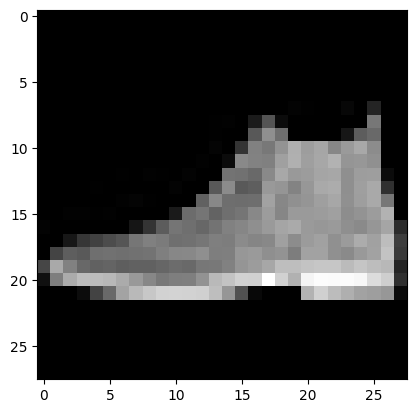

In [94]:
batch, images = next(iter(test_dataloader))
plt.imshow(batch[0].squeeze(), cmap="gray")

In [100]:
y_pred = model(batch[0].unsqueeze(0))
class_names[y_pred.argmax(dim=1)]

'Ankle boot'

In [101]:
import pandas as pd
df = pd.DataFrame({
    "model_name": ["FashionMNISTModelV0", "FashionMNISTModelV1", "FashionMNISTModelV2"],
    "model_loss": [0.48461, 0.68500, 0.31976],
    "model_acc": [82.85, 75.02, 88.20],
})
df

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.48461,82.85
1,FashionMNISTModelV1,0.68500,75.02
2,FashionMNISTModelV2,0.31976,88.20


Text(0, 0.5, 'model')

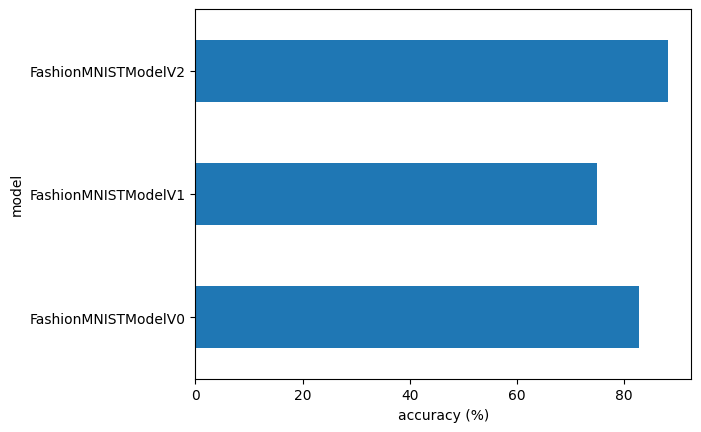

In [103]:
df.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

#### 9. Make and evaluate random predictions with best model

In [124]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # unsqueeze to add batch dimension

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)


            # Get prediction probability (logit -> probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred label (prediction prob -> pred label)
            pred_label = pred_prob.argmax(dim=0)
            pred_probs.append(pred_label)

    # Stack the pred probs in a tensor (list -> tensor)
    return torch.stack(pred_probs)

In [107]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample
test_samples[0].squeeze().shape

torch.Size([28, 28])

Text(0.5, 1.0, 'Sandal')

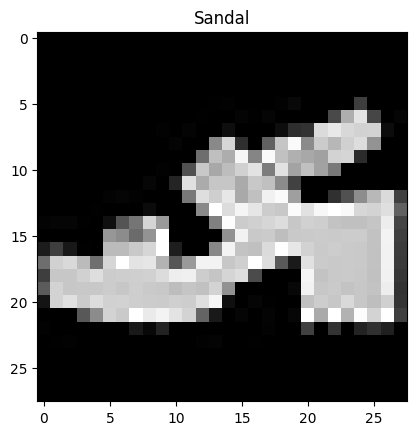

In [106]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [126]:
pred_probs = make_predictions(model=model, data=test_samples)

# View first two prediction probabilities
pred_probs

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

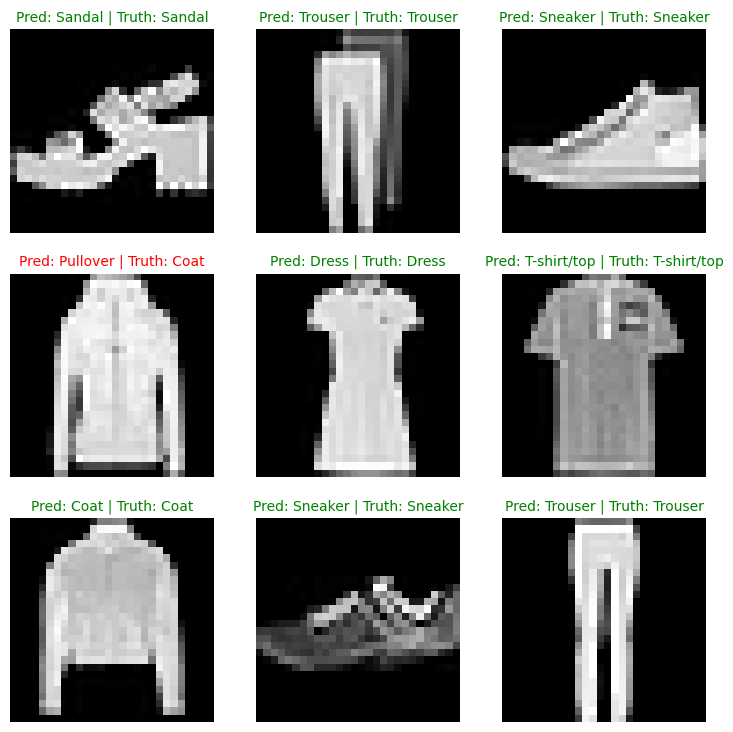

In [127]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_prob = pred_probs[i].item()
    pred_label = class_names[pred_prob]
    true_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {true_label}"
    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False)

# when we plot multiple truth/pred along with the image in a grid format, we can notice some things:
# 1. Our model could be better than we expected (wrong predictions are due to confusion)
#    the model made an appropriate prediction that turned out to be wrong
# 2. Our model could be worse than we expected
# 3. Spot confusion and problems in the dataset   

#### 10. Make a confusion matrix for further prediction evaluation

1. Make predictions with trained model on test data
2. Create confusion matrix using `torchmetrics.ConfusionMatrix`
3. Plot confusion matrix using [mlxtend](https://rasbt.github.io/mlxtend) `mlxtend.plotting.confusion_matrix`

In [148]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Store prediction
        y_preds.append(y_pred.cpu())

# 2. Convert prediction and truth labels into tensors
y_preds_tensor = torch.cat(y_preds)
len(y_preds_tensor)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 213.22it/s]


10000

In [133]:
from torchmetrics import ConfusionMatrix
target = torch.tensor([1, 1, 0, 0])
preds = torch.tensor([0, 1, 0, 0])
conf_mat = ConfusionMatrix(num_classes=2, task='binary')
result = conf_mat(preds, target)
result

tensor([[2, 0],
        [1, 1]])

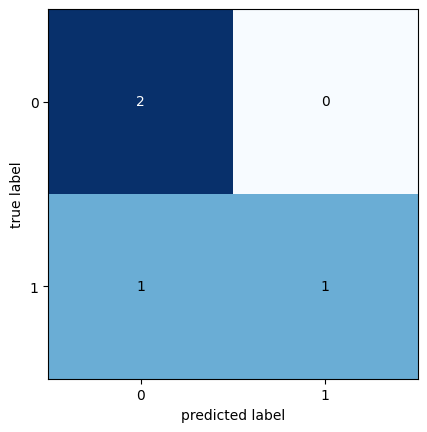

In [135]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=result.numpy())
plt.show()

In [149]:
# setup confusion matrix instance and compare predictions to targets

conf_mat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
conf_mat_tensor = conf_mat(y_preds_tensor, test_data.targets)
conf_mat_tensor

tensor([[855,   3,  10,  10,   4,   1, 110,   0,   7,   0],
        [  2, 974,   1,  14,   2,   0,   5,   0,   2,   0],
        [ 22,   0, 844,   8,  66,   1,  58,   0,   1,   0],
        [ 48,   9,  13, 845,  25,   0,  55,   0,   3,   2],
        [  3,   1, 103,  32, 761,   0, 100,   0,   0,   0],
        [  0,   0,   0,   1,   0, 968,   0,  18,   2,  11],
        [145,   2,  93,  20,  62,   1, 670,   0,   7,   0],
        [  0,   0,   0,   0,   0,   8,   0, 973,   0,  19],
        [  3,   1,   5,   7,   5,   2,   5,   5, 967,   0],
        [  0,   0,   0,   0,   0,   4,   1,  32,   0, 963]])

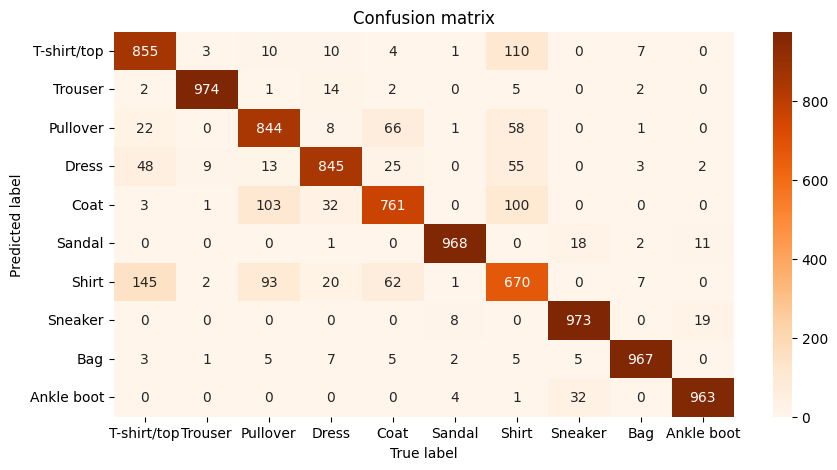

In [166]:
import seaborn as sns
# 3. Plot the confusion matrix (seaborn heatmap)
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(
    conf_mat_tensor.numpy(), 
    fmt="d", 
    annot=True, 
    cbar=True, 
    cmap="Oranges",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion matrix")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

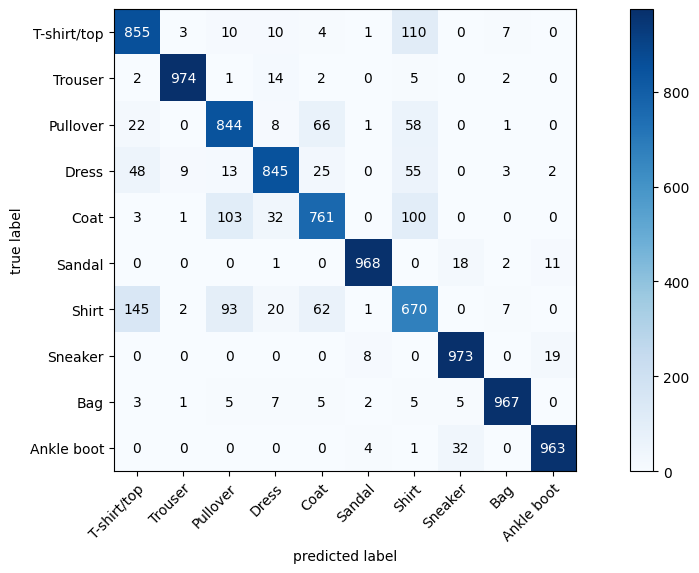

In [165]:
# 3. Plot the confusion matrix (mlxtend)
fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(), 
    class_names=class_names, 
    figsize=(14, 6), 
    colorbar=True)
plt.show()

In [ ]:
#### 11. Save and load the model

In [167]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "le_10_tinyVGG.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
try:
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
except:
    print(f"Unable to save model to: {MODEL_SAVE_PATH}")

In [173]:
# load back in our model
loaded_model = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)
loaded_model_results = eval_model(loaded_model, test_dataloader, loss_fn, accuracy_fn, device)
loaded_model_results

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:02<00:00, 126.52it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31975528597831726,
 'model_acc': tensor(0.8820)}

In [175]:
torch.isclose(model_results["model_acc"], loaded_model_results["model_acc"], atol=1e-02)

tensor(True)

[Exercises/Resources](https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises)